In [31]:
import torch
import itertools
import matplotlib.pyplot as plt
from random import randrange, choice, random
import copy

In [32]:
def actionToWords(a):
    # wmap = ["LEFT", "DOWN", "UP", "RIGHT", "STAY"]
    wmap = ["UP", "RIGHT", "LEFT", "DOWN", "STAY"]    
    if isinstance(a, int):
        return wmap[a]
    else:
        return list(itertools.compress(wmap, a))

# Task 1

In [33]:
class Maze:
    def __init__(self, dS, dA, actions, goal, obstacles):
        self.dS = dS
        self.dA = dA
        self.goal = goal
        self.actions = actions
        self.obstacles = set(obstacles)
        self.Psp_sa, self.Rsp_sa = None, None
        self.build()
        # layout for visualization
        layout = torch.zeros([dS, dS])
        for x, y in obstacles:
            layout[x, y] = 1
        layout[goal] = 2
        self.layout = layout
        
    def get_random_state(self):
        dS = self.dS
        return choice(list(filter(self.validState, itertools.product(range(dS), repeat=2))))
        # return (0,0)
        
    def get_trajectory_from_policy(self, s0, pi, num_iteration=10):
        if not self.validState(s0):
            print("State not valid")
            return []
        trajectory = [s0]
        s = s0
        for i in range(num_iteration):
            sp, r = self.step(s, pi[s])
            trajectory.append(sp)
            s = sp
        return trajectory
    
    def visualize_trajectory(self, trajectory):
        if not trajectory:
            return
        s0 = trajectory[0]
        sx = [t[0] for t in trajectory[1:-1]]
        sy = [t[1] for t in trajectory[1:-1]]
        st = trajectory[-1]
        # m = copy.deepcopy(self.layout)
        # for s in trajectory:
        #     m[s[0], s[1]] = 4 # x,y or y,x ?
        # ax, fig = self.visualize_matrix(m)
        # plt.scatter(s0[0], s0[1])
        # plt.show()
        # return ax, fig
        fig, ax = plt.subplots()
        plt.xlim(-0.5, dS-0.5)
        plt.ylim(-0.5, dS-0.5)
        # set up ticks and grid
        minor_ticks = [i+0.5 for i in range(dS)]
        major_ticks = range(dS)
        ax.set_xticks(minor_ticks, minor=True)
        ax.set_yticks(minor_ticks, minor=True)
        ax.set_xticks(major_ticks)
        ax.set_yticks(major_ticks)
        ax.grid(which="minor")
        plt.gca().invert_yaxis()
        
        
        plt.scatter(sx, sy, c="y")
        plt.scatter(st[0], st[1], c="g") # end_state
        plt.scatter(s0[0], s0[1], c="b") # initial_state
        plt.imshow(self.layout.T, cmap="binary")
        return ax, fig
    
    def step(self, s, a):
        goal = self.goal
        if isinstance(a, int):
            a = self.actions[a]
        else:
            a = self.actions[int(torch.nonzero(a)[0][0])]

        if s == goal:
            return (s, 0)
        sp = (s[0]+a[0], s[1]+a[1])
        if self.validState(sp):
            return (sp, 0) if sp == goal else (sp, -1)
        return s, -1 # s can't be goal because of the check earlier
        
    def visualize(self, s):
        fig, ax = plt.subplots()
        plt.xlim(-0.5, dS-0.5)
        plt.ylim(-0.5, dS-0.5)
        # set up ticks and grid
        minor_ticks = [i+0.5 for i in range(dS)]
        major_ticks = range(dS)
        ax.set_xticks(minor_ticks, minor=True)
        ax.set_yticks(minor_ticks, minor=True)
        ax.set_xticks(major_ticks)
        ax.set_yticks(major_ticks)
        ax.grid(which="minor")
        plt.gca().invert_yaxis()
        
        plt.scatter(s[0], s[1]) # current state
        plt.imshow(self.layout.T, cmap="binary")
        return fig
    
    def visualize_matrix(self, m):
        dS = self.dS
        fig, ax = plt.subplots()
        ax.matshow(m.T, cmap=plt.cm.Blues)

        for i in range(dS):
            for j in range(dS):
                c = float(m[i,j])
                ax.text(i, j, "{:.2f}".format(c), va='center', ha='center')
        return ax, fig

    def validState(self, s):
        if s in self.obstacles:
            return False
        dS = self.dS
        x, y = s
        # boundary check
        if 0 <= x < dS and 0 <= y < dS:
            return True
        return False
    
    
    def build(self):
        dS, dA, goal, actions = self.dS, self.dA, self.goal, self.actions
        # dynamics tensor with dimensions: |dS| x |dS| x |dA| x |dS| x |dS| x 1, where the 
        # dimensions are S₁, S₂, A, S₁′, S₂′. e.g., S₂ is the current second coordinate of the state
        # and S₁′ is the first coordinate of the state at the next time step.
        # Ps′_sa = zeros(dS, dS, dA, dS, dS)
        self.Psp_sa = torch.zeros([dS, dS, dA, dS, dS], dtype=torch.int32)
        # the reward tensor with the same dimension as the dynamics
        # reward is -1 on every state, and 0 at the Goal state.
        # Rs′sa  = -ones(dS, dS, dA, dS, dS)
        self.Rsp_sa = torch.full([dS, dS, dA, dS, dS], -1)
        # iterate over the valid states
        for s in filter(self.validState, itertools.product(range(dS), repeat=2)):
            if s == goal:
                self.Psp_sa[s[0], s[1], :, s[0], s[1]] = 1.0 # all the actions get prob 1 at the goal 
                self.Rsp_sa[:, :, :, s[0], s[1]] = 0.0 # all the actions get reward 0
                continue
            for i, a in enumerate(actions): # the same action set at each state 
                # if "next state is valid" move to it, otherwise stay at place 
                s_next = (s[0]+a[0], s[1]+a[1])
                s_next = s_next if self.validState(s_next) else s
                self.Psp_sa[s[0], s[1], i, s_next[0], s_next[1]] = 1.0

        #"sanity test:" forall a, s : sum_s′ Ps′_sa = 1 
        for a, s in itertools.product(range(len(actions)), filter(self.validState, itertools.product(range(dS), repeat=2))):
            # print(s, a)
            # print(self.Ps_sa[s[0], s[1], a, :, :])
            assert sum(torch.flatten(self.Psp_sa[s[0], s[1], a, :, :])) == 1
            
            
    def getRandomPolicy(self, equiprobable=False):
        dS, dA = self.dS, self.dA
        policy = torch.zeros([dS, dS, dA])
        for s in filter(self.validState, itertools.product(range(dS), repeat=2)):
            if equiprobable:
                for i in range(dA):
                    policy[s[0], s[1], i] = 1/dA
            else:
                randomAction = randrange(dA)
                policy[s[0], s[1], randomAction] = 1.0
        return policy
    
    def setOptimalPolicyFromGoal(self, policy, radius=2):
        # assume no obstacles in that radius
        # Up,      Right,       Left,       Down,     Stay
        # hard code it to be radius 2 for now
        for i in range(dS-radius-1, dS-1):
            down_right_action = torch.tensor([0, 0.5, 0, 0.5, 0])
            for j in range(dS-radius-1, dS-1):
                policy[i, j] = down_right_action
        for i in range(dS-radius-1, dS-1):
            policy[i, dS-1] = torch.tensor([0, 1.0, 0, 0, 0])
            policy[dS-1, i] = torch.tensor([0, 0, 0, 1.0, 0])
            
    
    def policy_evaluation(self, policy, gamma=1, threshold=0.01):
        Psp_sa, Rsp_sa = self.Psp_sa, self.Rsp_sa
        actions = self.actions
        dS = self.dS
        v = torch.zeros([dS, dS])
        while True:
            v_next = torch.zeros([dS, dS])
            for s in filter(self.validState, itertools.product(range(dS), repeat=2)):
                for i, _ in enumerate(actions):
                    if policy[s[0], s[1], i] == 0:
                        continue
                    for sp in filter(self.validState, itertools.product(range(dS), repeat=2)):
                        if Psp_sa[s[0], s[1], i, sp[0], sp[1]] == 0:
                            continue
                        # if s == (9,8) and sp == (9, 9):
                        #     print (Rsp_sa[s[0], s[1], i, sp[0], sp[1]])
                        save = (Rsp_sa[s[0], s[1], i, sp[0], sp[1]] + gamma * v[sp[0], sp[1]])
                        v_next[s[0],s[1]] += policy[s[0], s[1], i] * Psp_sa[s[0], s[1], i, sp[0], sp[1]] * save
                        #print(save)
                #print(f"state: {s}, counter: {counter}")
            max_delta = torch.max(torch.abs(v - v_next))
            # print(max_delta)
            v = v_next.clone()
            if max_delta <= threshold:
                 break
        return v
    
    def policy_improvement(self, policy, v, gamma=1):
        optimal_policy_found = True

        Psp_sa, Rsp_sa = self.Psp_sa, self.Rsp_sa
        actions = self.actions
        for s in filter(self.validState, itertools.product(range(dS), repeat=2)):
            val_max = v[s]
            for i, _ in enumerate(actions):
                val = 0
                for sp in filter(self.validState, itertools.product(range(dS), repeat=2)):
                    if Psp_sa[s[0], s[1], i, sp[0], sp[1]] == 0:
                        continue
                    tmp = Rsp_sa[s[0], s[1], i, sp[0], sp[1]] + gamma * v[sp[0], sp[1]]
                    val += Psp_sa[s[0], s[1], i, sp[0], sp[1]] * tmp
                if val > val_max and policy[s[0], s[1], i] != 1:
                    print(f"{val}>{val_max} at state {s} with action {i}")
                    policy[s[0], s[1]] = torch.zeros([5])
                    policy[s[0], s[1], i] = 1
                    optimal_policy_found = False
        return optimal_policy_found
                           
    def policy_iteration(self, policy, gamma, threshold, max_iteration=10):
        for i in range(max_iteration):
            v = self.policy_evaluation(policy, gamma=gamma, threshold=threshold)
            found = self.policy_improvement(policy, v, gamma=gamma)
            ax, fig = self.visualize_matrix(v)
            plt.show()
            fig.savefig(f't4-{i}.jpg')
            if found:
                return v, policy
            
        print("Reaches max_iteration and returns")
        return v, policy
                          
    def q_learning(self, max_ep, max_step, eps, gamma=0.8, alpha=0.1):
        # Create Q Table
        Q = torch.zeros([dS, dS, dA])
        rewards = []
        
        print_per_iteration = 500
        for ep in range(max_ep):
            if ep % print_per_iteration == 0:
                print(f"Episode: {ep}/{max_ep}")
            s = maze.get_random_state()
            total_reward = 0
            for i in range(max_step):
                a = Maze.greedy_pick_action(Q[s[0], s[1]], eps)
                sp, r = self.step(s, a)
                total_reward += r
                ap = Maze.greedy_pick_action(Q[sp[0], sp[1]], 0)
                td = r + gamma * Q[sp[0], sp[1], ap] - Q[s[0], s[1], a]
                Q[s[0], s[1], a] += alpha * td 
                if sp == self.goal:
                    break
                s = sp
            rewards.append(total_reward)
        return Q, rewards
    
    def sarsa_learning(self, max_ep, max_step, eps, gamma=0.8, alpha=0.1):
        # Create Q Table. Yes, SARSA also make use of Q table. It isn't Q-learning specific
        Q = torch.zeros([dS, dS, dA])
        rewards = []
        
        print_per_iteration = 500
        for ep in range(max_ep):
            if ep % print_per_iteration == 0:
                print(f"Episode: {ep}/{max_ep}")
            s = maze.get_random_state()
            total_reward = 0
            for i in range(max_step):
                a = Maze.greedy_pick_action(Q[s[0], s[1]], eps)
                sp, r = self.step(s, a)
                total_reward += r
                # Only the way to pick a' is change, SARSA use the same policy that picks a as above
                # Compare to Q-learning, which is off-policy and uses the absolute-greedy in picking a' (eps=0)
                ap = Maze.greedy_pick_action(Q[sp[0], sp[1]], eps) 
                td = r + gamma * Q[sp[0], sp[1], ap] - Q[s[0], s[1], a]
                Q[s[0], s[1], a] += alpha * td 
                if sp == self.goal:
                    break
                s = sp
            rewards.append(total_reward)
        return Q, rewards
    
    @staticmethod
    def greedy_pick_action(qa, eps=0):
        if random() >= eps: # pick the greedy action
            return int(torch.argmax(qa))
        else: # randomly pick an action
            return randrange(int(qa.size()[0]))
    
    def test(self):
        Psp_sa = self.Psp_sa
        Rsp_sa = self.Rsp_sa
        s = (9, 8)
        sp = (9, 9)
        a = 3
        print(f"Psp_sa: {Psp_sa[s[0], s[1], a, sp[0], sp[1]]}")
        print(f"Rsp_sa: {Rsp_sa[s[0], s[1], a, sp[0], sp[1]]}")
        print(self.validState(s))
        
# Initialize maze object        
# Configurations
obst1 = [(x, 2) for x in range(3)]
obst2 = [(3, y) for y in range(9, 6, -1)]
obst3 = [(x, 5) for x in range(9, 6, -1)]
dS = 10
#Up, Right, Left, Down, Stay
actions = [(0, -1), (1, 0), (-1, 0), (0, 1), (0, 0)]
dA = len(actions)
goal = (9,9)
obstacles = obst1 + obst2 + obst3
maze = Maze(dS, dA, actions, goal, obstacles)

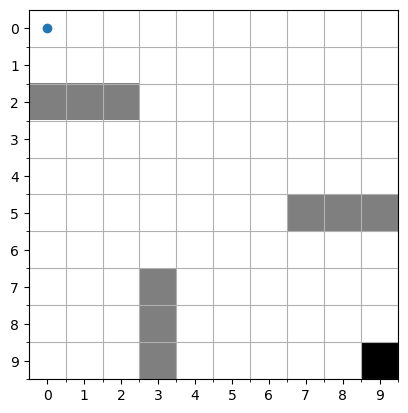

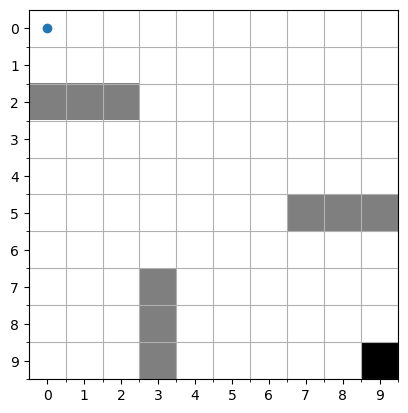

In [34]:
maze.visualize((0,0))

# Task 2

(<Axes: >, <Figure size 640x480 with 1 Axes>)

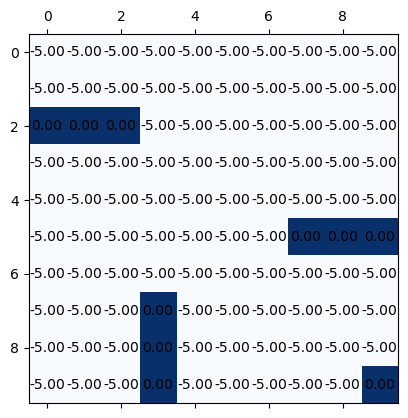

In [35]:
pi1 = maze.getRandomPolicy()
v1 = maze.policy_evaluation(pi1, gamma=0.8, threshold=0.001)
maze.visualize_matrix(v1)

In [36]:
print("Policy at s=(9,8) is: {}".format(actionToWords(pi1[9,8])))
print("Policy at s=(8,9) is: {}".format(actionToWords(pi1[8,9])))

Policy at s=(9,8) is: ['LEFT']
Policy at s=(8,9) is: ['UP']


# Task 3

(<Axes: >, <Figure size 640x480 with 1 Axes>)

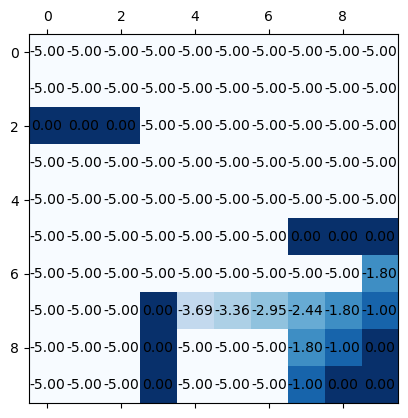

In [37]:
pi2 = maze.getRandomPolicy()
maze.setOptimalPolicyFromGoal(pi2)
v2 = maze.policy_evaluation(pi2, gamma=0.8, threshold=0.001)
maze.visualize_matrix(v2)

In [38]:
print("Policy at s=(5,9) is: {}".format(actionToWords(pi2[5,9])))
print("Policy at s=(7,6) is: {}".format(actionToWords(pi2[7,6])))

Policy at s=(5,9) is: ['DOWN']
Policy at s=(7,6) is: ['STAY']


# Task 4

-1.0>-4.996038913726807 at state (8, 8) with action 1
0.0>-4.996038913726807 at state (8, 9) with action 1
-1.0>-4.996038913726807 at state (9, 7) with action 3


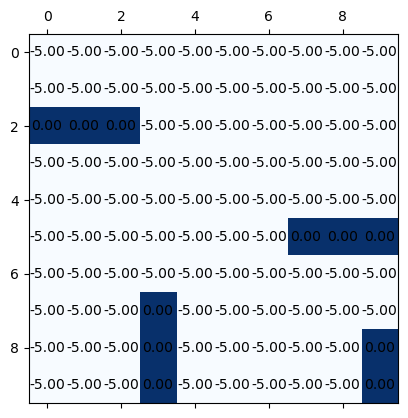

-2.952000141143799>-4.996038913726807 at state (5, 8) with action 1
-2.952000141143799>-4.996038913726807 at state (6, 7) with action 3
-2.952000141143799>-4.996038913726807 at state (6, 9) with action 0
-2.440000057220459>-4.996038913726807 at state (7, 7) with action 3
-2.440000057220459>-4.996038913726807 at state (7, 9) with action 0
-1.0>-4.996038913726807 at state (7, 9) with action 1
-1.7999999523162842>-4.996038913726807 at state (8, 7) with action 1
-1.7999999523162842>-4.996038913726807 at state (8, 7) with action 3
-1.7999999523162842>-4.996038913726807 at state (9, 6) with action 3


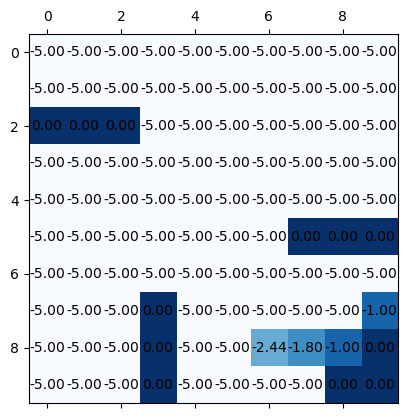

-3.361600160598755>-4.996038913726807 at state (4, 8) with action 1
-3.6892802715301514>-4.996038913726807 at state (4, 9) with action 1
-3.361600160598755>-4.996038913726807 at state (5, 7) with action 1
-3.361600160598755>-4.996038913726807 at state (5, 7) with action 3
-3.361600160598755>-4.996038913726807 at state (6, 6) with action 1
-3.361600160598755>-4.996038913726807 at state (6, 6) with action 3
-1.7999999523162842>-2.952000141143799 at state (6, 9) with action 1
-2.440000057220459>-3.361600160598755 at state (8, 6) with action 1
-2.440000057220459>-3.361600160598755 at state (8, 6) with action 3


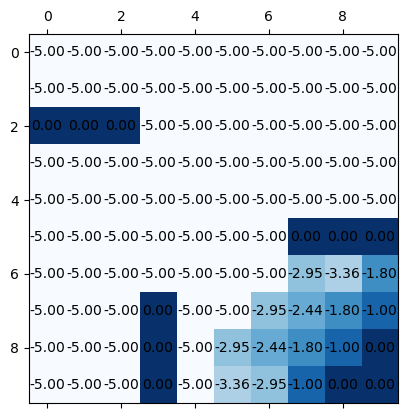

-4.161139488220215>-4.996038913726807 at state (4, 5) with action 1
-3.9514243602752686>-4.996038913726807 at state (4, 6) with action 1
-3.9514243602752686>-4.996038913726807 at state (4, 6) with action 3
-4.161139488220215>-4.996038913726807 at state (5, 4) with action 3
-2.440000057220459>-3.361600160598755 at state (5, 9) with action 1
-4.161139488220215>-4.996038913726807 at state (6, 5) with action 2
-3.6892802715301514>-4.996038913726807 at state (6, 5) with action 3


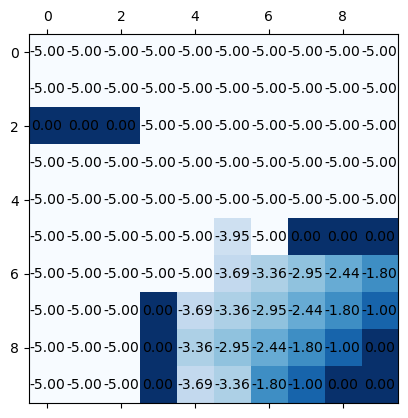

-4.328911781311035>-4.996038913726807 at state (3, 5) with action 1
-4.161139488220215>-4.996038913726807 at state (3, 6) with action 1
-4.328911781311035>-4.996038913726807 at state (4, 4) with action 1
-4.328911781311035>-4.996038913726807 at state (4, 4) with action 3
-4.328911781311035>-4.996038913726807 at state (5, 3) with action 3
-4.161139488220215>-4.996038913726807 at state (6, 3) with action 3
-4.161139488220215>-4.996038913726807 at state (7, 4) with action 2


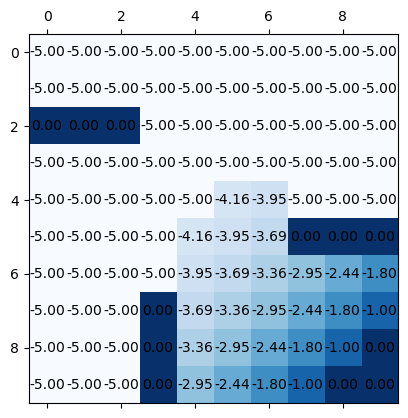

-4.46312952041626>-4.996038913726807 at state (2, 5) with action 1
-4.328911781311035>-4.996038913726807 at state (2, 6) with action 1
-4.5705037117004395>-4.996038913726807 at state (3, 3) with action 1
-4.46312952041626>-4.996038913726807 at state (3, 4) with action 1
-4.46312952041626>-4.996038913726807 at state (3, 4) with action 3
-4.5705037117004395>-4.996038913726807 at state (4, 2) with action 3
-4.46312952041626>-4.996038913726807 at state (5, 2) with action 3
-4.328911781311035>-4.996038913726807 at state (6, 2) with action 3
-4.328911781311035>-4.996038913726807 at state (7, 3) with action 2
-4.328911781311035>-4.996038913726807 at state (7, 3) with action 3
-4.328911781311035>-4.996038913726807 at state (8, 4) with action 2


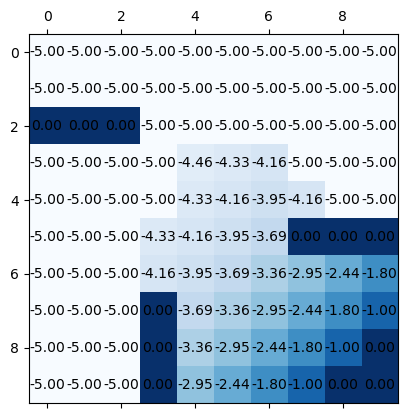

-4.725122451782227>-4.996038913726807 at state (0, 4) with action 1
-4.656403064727783>-4.996038913726807 at state (0, 5) with action 1
-4.725122451782227>-4.996038913726807 at state (1, 3) with action 1
-4.725122451782227>-4.996038913726807 at state (1, 3) with action 3
-4.656403064727783>-4.996038913726807 at state (1, 6) with action 0
-4.46312952041626>-4.996038913726807 at state (1, 6) with action 1
-4.46312952041626>-4.996038913726807 at state (2, 7) with action 0
-4.656403064727783>-4.996038913726807 at state (3, 2) with action 1
-4.656403064727783>-4.996038913726807 at state (3, 2) with action 3
-4.656403064727783>-4.996038913726807 at state (4, 1) with action 3
-4.5705037117004395>-4.996038913726807 at state (5, 1) with action 3
-4.46312952041626>-4.996038913726807 at state (6, 1) with action 3
-4.46312952041626>-4.996038913726807 at state (7, 2) with action 2
-4.46312952041626>-4.996038913726807 at state (7, 2) with action 3
-4.46312952041626>-4.996038913726807 at state (8, 3)

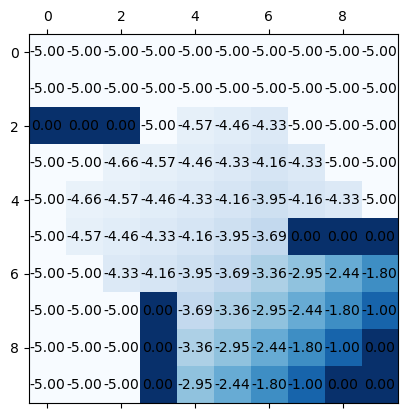

-4.780097961425781>-4.996038913726807 at state (0, 3) with action 1
-4.780097961425781>-4.996038913726807 at state (0, 3) with action 3
-4.725122451782227>-4.996038913726807 at state (0, 6) with action 0
-4.5705037117004395>-4.996038913726807 at state (0, 6) with action 1
-4.5705037117004395>-4.996038913726807 at state (1, 7) with action 0
-4.5705037117004395>-4.996038913726807 at state (1, 7) with action 1
-4.656403064727783>-4.996038913726807 at state (1, 8) with action 1
-4.725122451782227>-4.996038913726807 at state (1, 9) with action 1
-4.780097961425781>-4.996038913726807 at state (2, 1) with action 1
-4.780097961425781>-4.996038913726807 at state (3, 0) with action 3
-4.725122451782227>-4.996038913726807 at state (4, 0) with action 3
-4.656403064727783>-4.996038913726807 at state (5, 0) with action 3
-4.5705037117004395>-4.996038913726807 at state (6, 0) with action 3
-4.5705037117004395>-4.996038913726807 at state (7, 1) with action 2
-4.5705037117004395>-4.996038913726807 at s

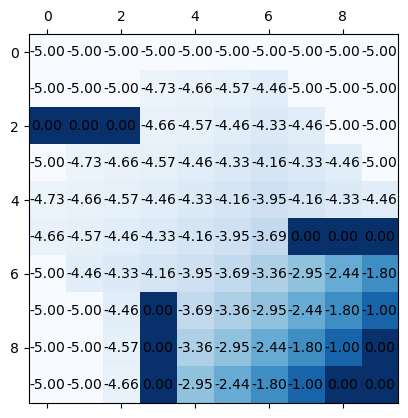

-4.725122451782227>-4.996038913726807 at state (0, 8) with action 0
-4.725122451782227>-4.996038913726807 at state (0, 8) with action 1
-4.780097961425781>-4.996038913726807 at state (0, 9) with action 1
-4.824078559875488>-4.996038913726807 at state (1, 1) with action 1
-4.824078559875488>-4.996038913726807 at state (2, 0) with action 1
-4.824078559875488>-4.996038913726807 at state (2, 0) with action 3
-4.725122451782227>-4.996038913726807 at state (8, 0) with action 2
-4.656403064727783>-4.996038913726807 at state (8, 1) with action 2
-4.656403064727783>-4.996038913726807 at state (8, 1) with action 3
-4.656403064727783>-4.996038913726807 at state (9, 2) with action 2
-4.656403064727783>-4.996038913726807 at state (9, 2) with action 3


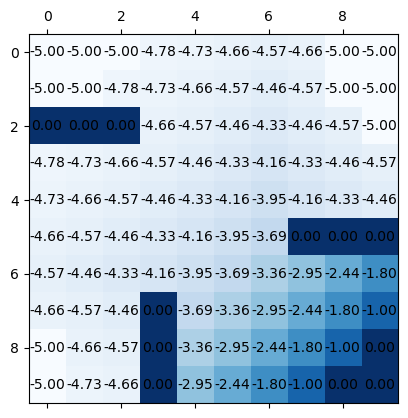

-4.8874101638793945>-4.996038913726807 at state (0, 0) with action 1
-4.859262943267822>-4.996038913726807 at state (0, 1) with action 1
-4.780097961425781>-4.996038913726807 at state (9, 0) with action 2
-4.725122451782227>-4.996038913726807 at state (9, 1) with action 2
-4.725122451782227>-4.996038913726807 at state (9, 1) with action 3


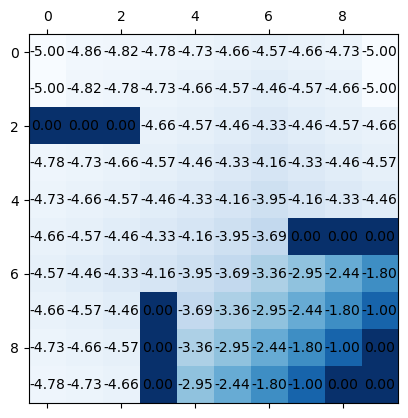

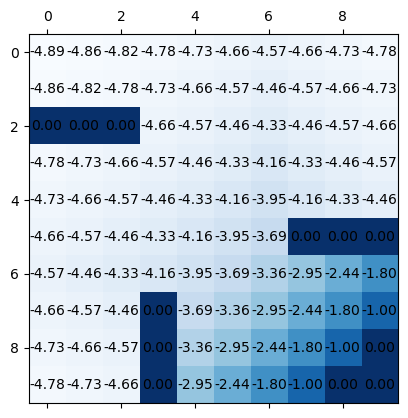

In [39]:
pi4 = maze.getRandomPolicy()
v, policy = maze.policy_iteration(pi4, gamma=0.8, threshold=0.001, max_iteration=100)

In [40]:
# All matrix or tensors are in x go down, y go right format,
# When it comes to visualization, we transpose it so that x go right, and y go down
# Hence, when we define action, we have
# actions = [(0, -1), (1, 0), (-1, 0), (0, 1), (0, 0)]
# Representing 0: Up, 1: Right, 2: Left, 3: Down, 4:Stay
# But for visualization, after trasposing:
# 0: Left, 1: Down, 2: Up, 3: Right, 4: Stay
# Hence, when looking at visualization, use the above action

# Task 5

## Random Policy

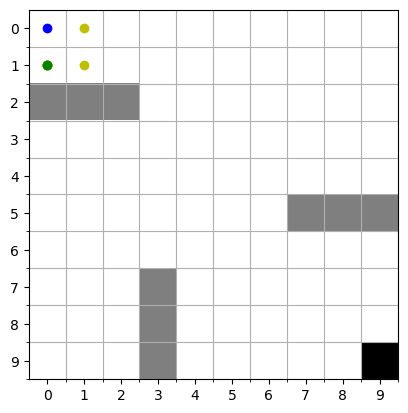

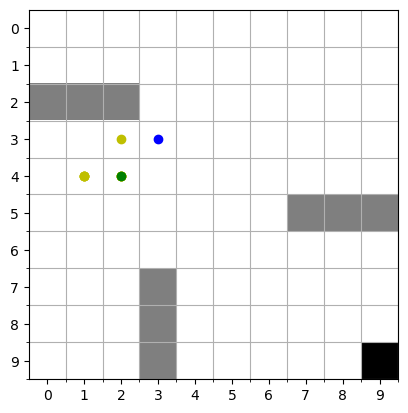

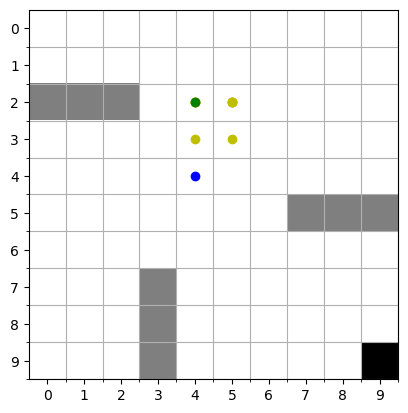

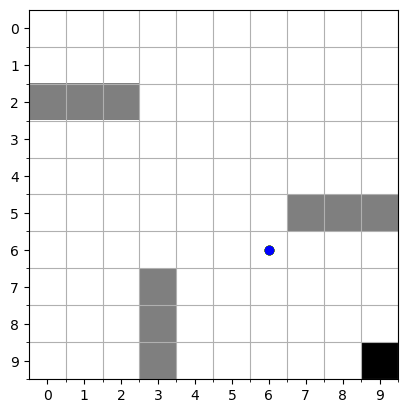

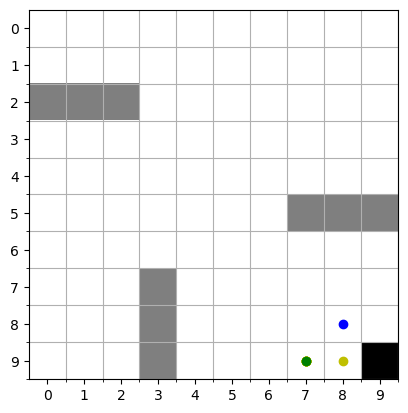

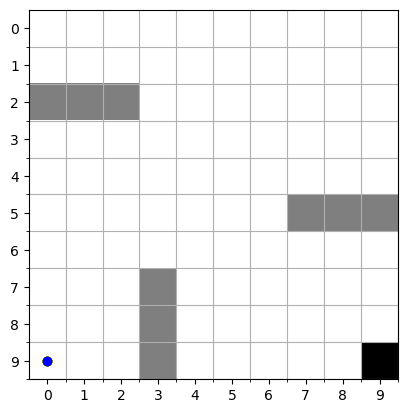

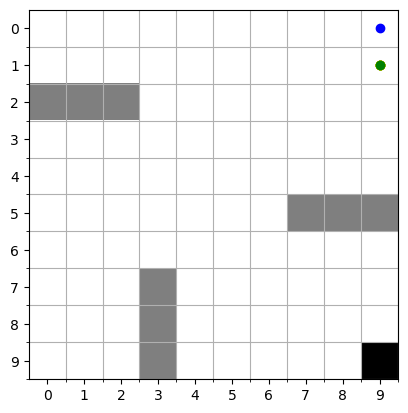

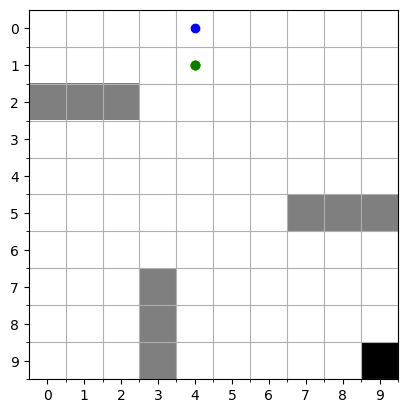

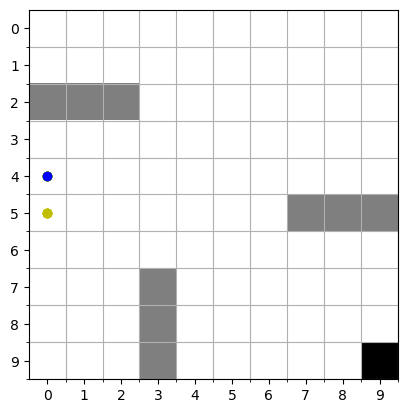

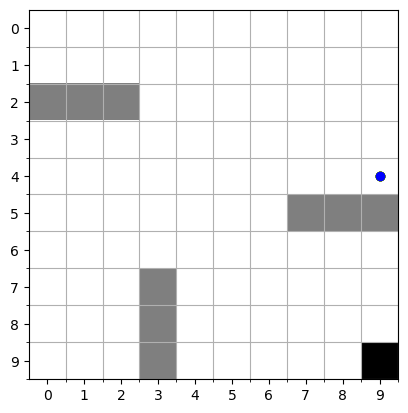

In [41]:
initial_states = [(0,0), (3,3), (4,4), (6,6), (8,8), (0,9), (9,0), (4,0), (0,4), (9,4)]
pi5 = maze.getRandomPolicy()
for i, s0 in enumerate(initial_states):
    trajectory = maze.get_trajectory_from_policy(s0, pi5)
    ax, fig = maze.visualize_trajectory(trajectory)
    fig.savefig(f't5a-{i}.jpg')

## Optimal Policy from Task 4

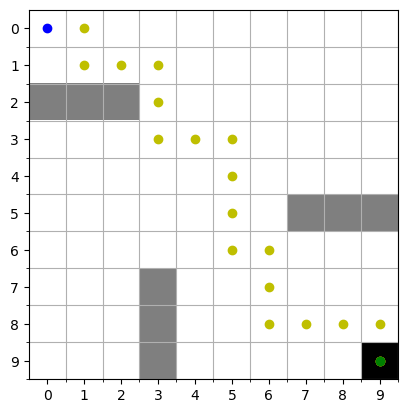

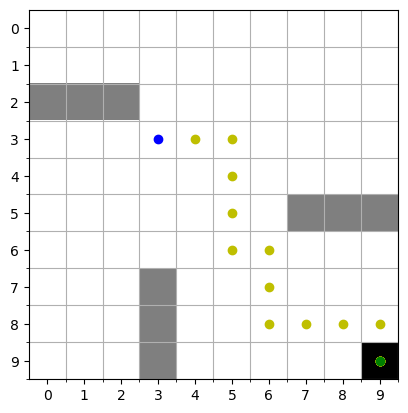

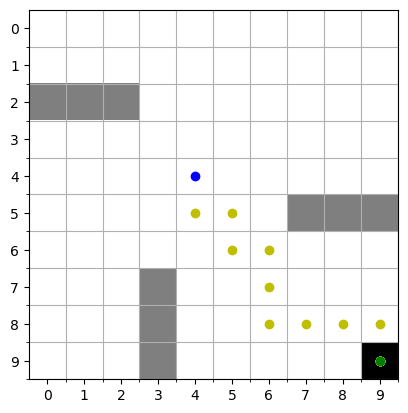

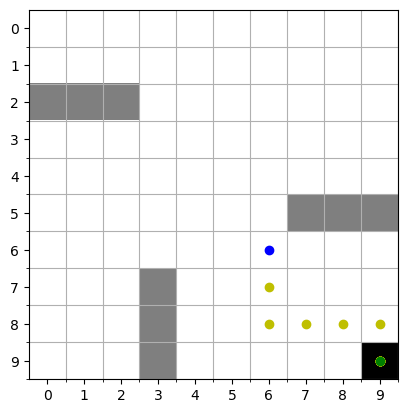

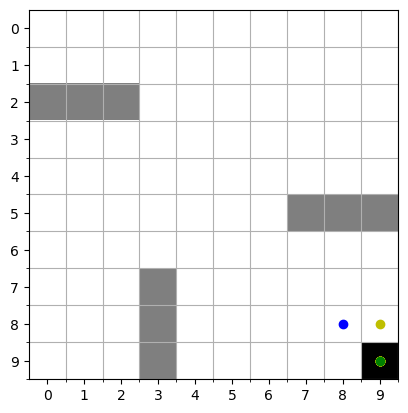

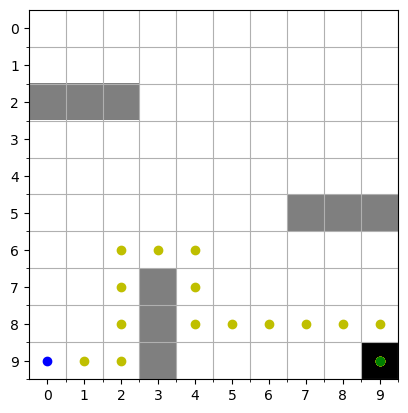

In [ ]:
initial_states = [(0,0), (3,3), (4,4), (6,6), (8,8), (0,9), (9,0), (4,0), (0,4), (9,4)]
for i, s0 in enumerate(initial_states):
    trajectory = maze.get_trajectory_from_policy(s0, pi4, num_iteration=20)
    ax, fig = maze.visualize_trajectory(trajectory)
    fig.savefig(f't5b-{i}.jpg')

# T6 Q-Learning

#### Note that there are two T5 in the hw instruction, automatically incremented)

In [ ]:
max_ep = 1000
Q, rewards = maze.q_learning(max_ep=max_ep, max_step=100, eps=0.2, gamma=0.8, alpha=0.1)
print(actionToWords(Maze.greedy_pick_action(Q[9,8])))
print(actionToWords(Maze.greedy_pick_action(Q[8,9])))

In [ ]:
# Run it five times, and collect accumulated rewards for plotting
num_runs = 5
rewards_across_runs = []
for _ in range(num_runs):
    Q, rewards = maze.q_learning(max_ep=max_ep, max_step=100, eps=0.2, gamma=0.8, alpha=0.1)
    rewards_across_runs.append(rewards)

In [ ]:
fig, ax = plt.subplots(nrows=num_runs, ncols=1, figsize=(30, 30))

for i in range(num_runs):
    ax[i].scatter(range(max_ep), rewards_across_runs[i])
    ax[i].set_ylabel("Accumulated Reward")
    ax[i].set_xlabel("Episode")
plt.show()

In [ ]:
#fig.savefig("f6-random-scatter-10000.jpg")

# T7 Sarsa

In [ ]:
Q, rewards = maze.sarsa_learning(max_ep=max_ep, max_step=100, eps=0.2, gamma=0.8, alpha=0.1)
print(actionToWords(Maze.greedy_pick_action(Q[9,8])))
print(actionToWords(Maze.greedy_pick_action(Q[8,9])))

In [ ]:
# Run it five times, and collect accumulated rewards for plotting
num_runs = 5
rewards_across_runs = []
for _ in range(num_runs):
    Q, rewards = maze.sarsa_learning(max_ep=max_ep, max_step=100, eps=0.2, gamma=0.8, alpha=0.1)
    rewards_across_runs.append(rewards)

In [ ]:
fig, ax = plt.subplots(nrows=num_runs, ncols=1, figsize=(30, 30))

for i in range(num_runs):
    #ax[i].plot(range(max_ep), rewards_across_runs[i])
    ax[i].scatter(range(max_ep), rewards_across_runs[i])
    ax[i].set_ylabel("Accumulated Reward")
    ax[i].set_xlabel("Episode")
plt.show()

In [ ]:
#fig.savefig("f7-random-plot-10000.jpg")

# T8 DQN